In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.interpolate import interp1d
import cosmology
import os
import numpy as np
from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
#%matplotlib inline

In [2]:
# COSMOS2015 photometry catalog from Laigle et al. 2016 (ftp://ftp.iap.fr/pub/from_users/hjmcc/COSMOS2015/)
# It will become important later because we are tying to build a legacy reference sample 
COSMOS2015 = fits.open('COSMOS2015_Laigle+_v2.1.fits')

Make basic sample selection from the COSMOS2015 photometric catalog:

7.2 < log M$_*$/M$_\odot$ < 11.0, z < 0.25, star-forming galaxies


In [3]:
# Make the basic cuts for sample1 7.2 < logM* < 11 
mask_basic = (COSMOS2015[1].data['MASS_MED'] > 7.2) & (COSMOS2015[1].data['MASS_MED'] < 11)
# star-forming (CLASS 0:quiescent/1:star-forming based on the NUV-R/R-J)
mask_basic *= COSMOS2015[1].data['CLASS'] == 1
# type=0   if galaxy
mask_basic *= COSMOS2015[1].data['TYPE'] == 0
# 0: UltraVISTA area, >=1 out of UltraVISTA
mask_basic *= COSMOS2015[1].data['FLAG_HJMCC'] == 0
# 0: good area, >=1 masked in optical broad-bands (P. Capak)
mask_basic *= COSMOS2015[1].data['FLAG_PETER'] == 0
# 1: 2deg2 COSMOS area
mask_basic *= COSMOS2015[1].data['FLAG_COSMOS'] == 1
# basic redshift cut z < 0.25
mask_sample1 = mask_basic * (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.25)

sample1 = COSMOS2015[1].data[mask_sample1]

# Spec_z catalog from /Users/alexie/Work/PhotozLaigle/OBSERVED_TARGETS_15April2015_withHeader.dat 
# good_z = Quality flag 3 <= Q_f <= 5 and 0 < z_spec < 9
mask_goodz = mask_sample1 * COSMOS2015[1].data['good_z']
sample_goodz = COSMOS2015[1].data[mask_goodz]

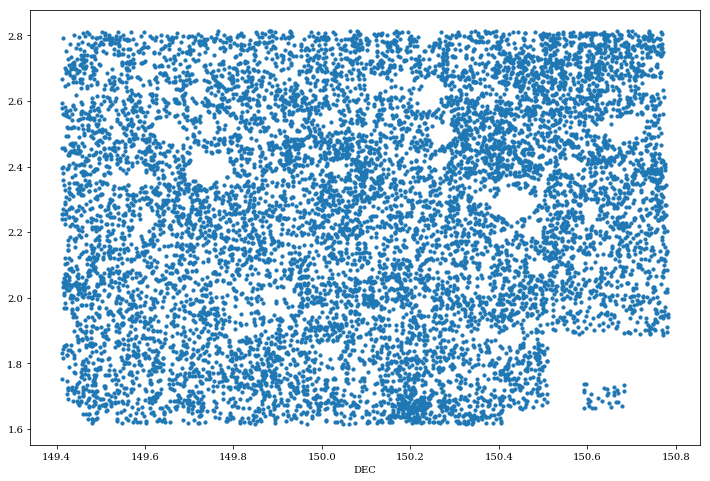

In [4]:
plt.scatter(sample1['ALPHA_J2000'],sample1['DELTA_J2000'],s=10)
plt.xlabel('RA')
plt.xlabel('DEC')
plt.show()

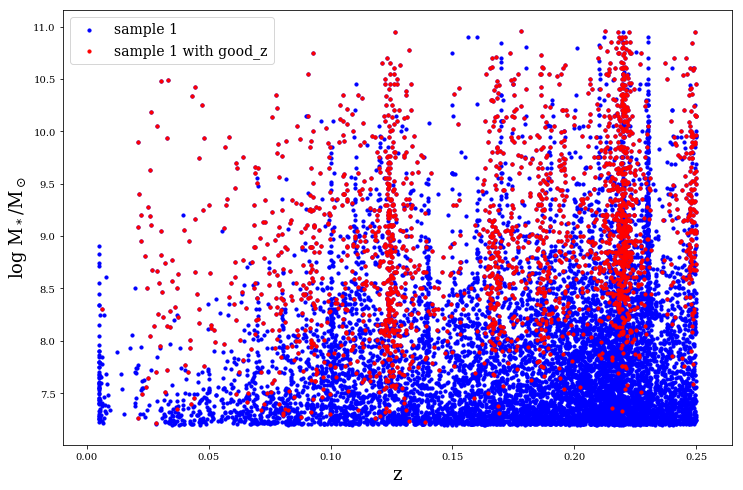

In [5]:
plt.scatter(sample1['redshift'],sample1['MASS_MED'],s=10,c='b',label='sample 1')
plt.scatter(sample_goodz['redshift'],sample_goodz['MASS_MED'],s=10,c='r',label='sample 1 with good_z')
plt.xlabel('z',fontsize=18)
plt.ylabel('log M$_*$/M$_\odot$',fontsize=18)
plt.legend(fontsize=14)
plt.show()

Here we make bins based on galaxy mass and calculate the numbers of galaxies in each bin per DEIMOS mask

In [6]:
# Priority = 100 (lower)
# Here we only want to target things that don't already have a specz
# *** Make a cut here on things that have a good specz already

mask_sample1_bin0 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 7.20) & (COSMOS2015[1].data['MASS_MED'] < 7.5) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin1 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 7.5) & (COSMOS2015[1].data['MASS_MED'] < 7.75) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin2 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 7.75) & (COSMOS2015[1].data['MASS_MED'] < 8.0) & (COSMOS2015[1].data['good_z'] == 0)

# Priority = 999 (high priority)
# Here we want to target $everything$, regardless of wheter or not a specz already exists.
# This is because we want to get Halpha sigma values

mask_sample1_bin3 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.0) & (COSMOS2015[1].data['MASS_MED'] < 8.25)
mask_sample1_bin4 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.25) & (COSMOS2015[1].data['MASS_MED'] < 8.5)
mask_sample1_bin5 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.5) & (COSMOS2015[1].data['MASS_MED'] < 8.75)
mask_sample1_bin6 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.75) & (COSMOS2015[1].data['MASS_MED'] < 9.0)

#priority = 100 (lower)
# *** Make a cut here on things that have a good specz already
mask_sample1_bin7 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 9.0) & (COSMOS2015[1].data['MASS_MED'] < 9.5) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin8 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 9.5) & (COSMOS2015[1].data['MASS_MED'] < 10.0) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin9 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 10.0) & (COSMOS2015[1].data['MASS_MED'] < 10.5) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin10 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 10.5) & (COSMOS2015[1].data['MASS_MED'] < 11.0) & (COSMOS2015[1].data['good_z'] == 0)

sample1_bin0 = COSMOS2015[1].data[mask_sample1_bin0]
sample1_bin1 = COSMOS2015[1].data[mask_sample1_bin1]
sample1_bin2 = COSMOS2015[1].data[mask_sample1_bin2]
sample1_bin3 = COSMOS2015[1].data[mask_sample1_bin3]
sample1_bin4 = COSMOS2015[1].data[mask_sample1_bin4]
sample1_bin5 = COSMOS2015[1].data[mask_sample1_bin5]
sample1_bin6 = COSMOS2015[1].data[mask_sample1_bin6]
sample1_bin7 = COSMOS2015[1].data[mask_sample1_bin7]
sample1_bin8 = COSMOS2015[1].data[mask_sample1_bin8]
sample1_bin9 = COSMOS2015[1].data[mask_sample1_bin9]
sample1_bin10 = COSMOS2015[1].data[mask_sample1_bin10]

In [7]:
COSMOS_area_estimate = (150.75-149.4)*(2.8-1.6)-(150.78-150.5)*(1.9-1.6) #deg^2
DEIMOS_FOV = 16 * 4 / 3600 #deg^2

number_bin0 = len(sample1_bin0) / COSMOS_area_estimate * DEIMOS_FOV
number_bin1 = len(sample1_bin1) / COSMOS_area_estimate * DEIMOS_FOV
number_bin2 = len(sample1_bin2) / COSMOS_area_estimate * DEIMOS_FOV
number_bin3 = len(sample1_bin3) / COSMOS_area_estimate * DEIMOS_FOV
number_bin4 = len(sample1_bin4) / COSMOS_area_estimate * DEIMOS_FOV
number_bin5 = len(sample1_bin5) / COSMOS_area_estimate * DEIMOS_FOV
number_bin6 = len(sample1_bin6) / COSMOS_area_estimate * DEIMOS_FOV
number_bin7 = len(sample1_bin7) / COSMOS_area_estimate * DEIMOS_FOV
number_bin8 = len(sample1_bin8) / COSMOS_area_estimate * DEIMOS_FOV
number_bin9 = len(sample1_bin9) / COSMOS_area_estimate * DEIMOS_FOV
number_bin10 = len(sample1_bin10) / COSMOS_area_estimate * DEIMOS_FOV
total_per_mask = number_bin0 + number_bin1 + number_bin2 + number_bin3 + number_bin4 + number_bin5 + number_bin6 + number_bin7 + number_bin8 + number_bin9 + number_bin10

total_per_mask_high = number_bin3 + number_bin4 + number_bin5 + number_bin6
# ***** print here the bin numbers, mass range, and priortity number, and average number per DEIMOS FOV
print('bin0,',' 7.20 < logM < 7.50,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin0)
print('bin1,',' 7.50 < logM < 7.75,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin1)
print('bin2,',' 7.75 < logM < 8.00,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin2)
print('\n')
print('bin3,',' 8.00 < logM < 8.25,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin3)
print('bin4,',' 8.25 < logM < 8.50,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin4)
print('bin5,',' 8.50 < logM < 8.75,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin5)
print('bin6,',' 8.75 < logM < 9.00,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin6)
print('\n')
print('bin7,',' 9.00 < logM < 9.50,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin7)
print('bin8,',' 9.50 < logM < 10.0,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin8)
print('bin9,',' 10.0 < logM < 10.5,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin9)
print('bin10,','10.5 < logM < 11.0,', 'priortity number = 100,', 'galaxies per DEIMOS mask =',number_bin10)

print()
print('total galaxies per DEIMOS mask =',total_per_mask)

print('\n -- high prioroty --')
print('high priority galaxies per DEIMOS mask =',total_per_mask_high)
print('high priority galaxies - all numbers =',total_per_mask_high *12)

# 7 8 9 10 high
# 3 4 5 6 medium
# 1 2 low
# 0 lower

bin0,  7.20 < logM < 7.50, priortity number = 100, galaxies per DEIMOS mask = 41.57407407407428
bin1,  7.50 < logM < 7.75, priortity number = 100, galaxies per DEIMOS mask = 16.296296296296376
bin2,  7.75 < logM < 8.00, priortity number = 100, galaxies per DEIMOS mask = 12.91666666666673


bin3,  8.00 < logM < 8.25, priortity number = 999, galaxies per DEIMOS mask = 12.233796296296356
bin4,  8.25 < logM < 8.50, priortity number = 999, galaxies per DEIMOS mask = 9.687500000000046
bin5,  8.50 < logM < 8.75, priortity number = 999, galaxies per DEIMOS mask = 7.835648148148186
bin6,  8.75 < logM < 9.00, priortity number = 999, galaxies per DEIMOS mask = 6.377314814814846


bin7,  9.00 < logM < 9.50, priortity number = 100, galaxies per DEIMOS mask = 4.305555555555577
bin8,  9.50 < logM < 10.0, priortity number = 100, galaxies per DEIMOS mask = 2.0138888888888986
bin9,  10.0 < logM < 10.5, priortity number = 100, galaxies per DEIMOS mask = 0.972222222222227
bin10, 10.5 < logM < 11.0, priort

In [8]:
mask_sample1_total = mask_sample1_bin0 | mask_sample1_bin1 | mask_sample1_bin2 | mask_sample1_bin3 | mask_sample1_bin4 | mask_sample1_bin5 | mask_sample1_bin6 | mask_sample1_bin7 | mask_sample1_bin8 | mask_sample1_bin9 | mask_sample1_bin10  
sample1_total = COSMOS2015[1].data[mask_sample1_total]

mask_sample_high_pcode = mask_sample1_bin3 | mask_sample1_bin4 | mask_sample1_bin5 | mask_sample1_bin6
sample_high_pcode = COSMOS2015[1].data[mask_sample_high_pcode]

mask_sample_lowz = mask_sample_high_pcode * (COSMOS2015[1].data['redshift'] < 0.15)
sample_lowz = COSMOS2015[1].data[mask_sample_lowz]

mask_sample_lowmass = mask_sample1_bin0 | mask_sample1_bin1 | mask_sample1_bin2
sample_lowmass = COSMOS2015[1].data[mask_sample_lowmass]

mask_sample_highmass = mask_sample1_bin7 | mask_sample1_bin8 | mask_sample1_bin9 | mask_sample1_bin10
sample_highmass = COSMOS2015[1].data[mask_sample_highmass]

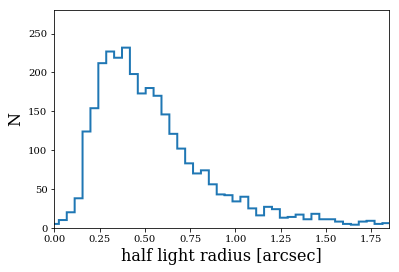

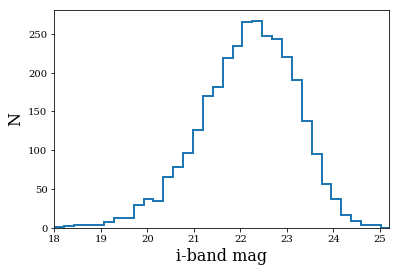

In [9]:
fig = plt.figure(figsize=(6,4))
plt.hist(sample_high_pcode['halflight_radius'],bins=2000,histtype='step',linewidth=2)
plt.xlabel('half light radius [arcsec]',fontsize=16)
plt.ylabel('N',fontsize=16)
plt.xlim(0,1.85)
plt.ylim(0,280)
#plt.savefig('Re_hist.png',dpi=300)
plt.show()

fig = plt.figure(figsize=(6,4))
plt.hist(sample_high_pcode['ip_MAG_AUTO'],bins=50,histtype='step',linewidth=2)
plt.xlabel('i-band mag',fontsize=16)
plt.ylabel('N',fontsize=16)
plt.xlim(18,25.2)
#plt.savefig('mag_hist.png',dpi=300)
plt.show()

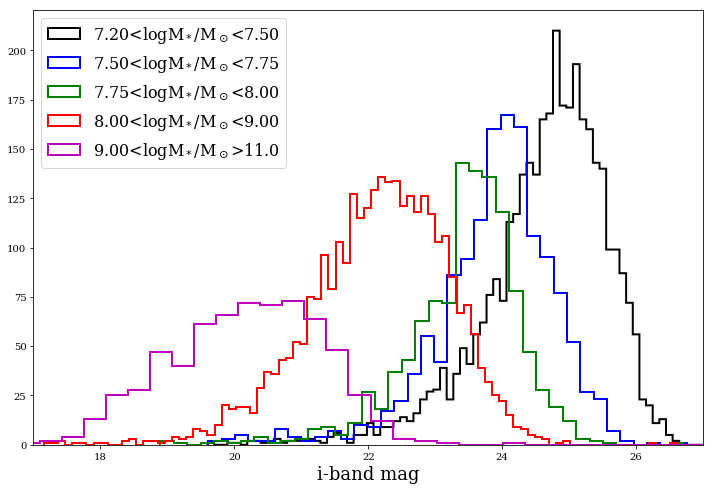

In [10]:
fig = plt.figure(figsize=(12,8))

#plt.hist(sample_lowmass['ip_MAG_AUTO'],bins=1000,histtype='step',linewidth=2,label='logM$_*$/M$_\odot$<8')
plt.hist(sample1_bin0['ip_MAG_AUTO'],bins=800,histtype='step',linewidth=2,label='7.20<logM$_*$/M$_\odot$<7.50',color='k')
plt.hist(sample1_bin1['ip_MAG_AUTO'],bins=400,histtype='step',linewidth=2,label='7.50<logM$_*$/M$_\odot$<7.75',color='b')
plt.hist(sample1_bin2['ip_MAG_AUTO'],bins=400,histtype='step',linewidth=2,label='7.75<logM$_*$/M$_\odot$<8.00',color='g')


plt.hist(sample_high_pcode['ip_MAG_AUTO'],bins=100,histtype='step',linewidth=2,label='8.00<logM$_*$/M$_\odot$<9.00',color='r')
plt.hist(sample_highmass['ip_MAG_AUTO'],bins=250,histtype='step',linewidth=2,label='9.00<logM$_*$/M$_\odot$>11.0',color='m')

plt.xlabel('i-band mag',fontsize=18)
plt.xlim(17,27)
plt.legend(loc='upper left',fontsize=16)
#plt.savefig('mag_hist_allsample.png',dpi=300)
plt.show()

Now we make the masks on the sky

In [11]:
Mask_FOV_1 = (sample1_total['ALPHA_J2000'] > 149.99) & (sample1_total['ALPHA_J2000'] < 150.257) & (sample1_total['DELTA_J2000'] > 2.483) & (sample1_total['DELTA_J2000'] < 2.55)
Mask_FOV_2 = (sample1_total['ALPHA_J2000'] > 149.99) & (sample1_total['ALPHA_J2000'] < 150.257) & (sample1_total['DELTA_J2000'] > 2.417) & (sample1_total['DELTA_J2000'] < 2.483)
Mask_FOV_3 = (sample1_total['ALPHA_J2000'] > 149.99) & (sample1_total['ALPHA_J2000'] < 150.257) & (sample1_total['DELTA_J2000'] > 2.350) & (sample1_total['DELTA_J2000'] < 2.417)
Mask_FOV_4 = (sample1_total['ALPHA_J2000'] > 149.99) & (sample1_total['ALPHA_J2000'] < 150.257) & (sample1_total['DELTA_J2000'] > 2.283) & (sample1_total['DELTA_J2000'] < 2.350)
Mask_FOV_5 = (sample1_total['ALPHA_J2000'] > 149.99) & (sample1_total['ALPHA_J2000'] < 150.257) & (sample1_total['DELTA_J2000'] > 2.217) & (sample1_total['DELTA_J2000'] < 2.283)
Mask_FOV_6 = (sample1_total['ALPHA_J2000'] > 149.99) & (sample1_total['ALPHA_J2000'] < 150.257) & (sample1_total['DELTA_J2000'] > 2.150) & (sample1_total['DELTA_J2000'] < 2.217)

sample_MASK_1 = sample1_total[Mask_FOV_1]
sample_MASK_2 = sample1_total[Mask_FOV_2]
sample_MASK_3 = sample1_total[Mask_FOV_3]
sample_MASK_4 = sample1_total[Mask_FOV_4]
sample_MASK_5 = sample1_total[Mask_FOV_5]
sample_MASK_6 = sample1_total[Mask_FOV_6]

In [12]:
# Convert the RADEC in to the right format
def convertRADEC(RA,DEC):

    raH = (RA/15).astype(int)
    raM = (((RA/15)-raH)*60).astype(int)
    raS = ((((RA/15)-raH)*60)-raM)*60
    #ra_hms = raH,raM,raS
    
    deg = (DEC).astype(int)
    decM = abs(((DEC-deg)*60).astype(int))
    decS = (abs((DEC-deg)*60)-decM)*60
    #dec_dms = deg,decM,decS
    
    return raH,raM,raS,deg,decM,decS

raH,raM,raS,deg,decM,decS = convertRADEC(sample_MASK_2['ALPHA_J2000'],sample_MASK_2['DELTA_J2000'])

In [13]:
# Generate a txt file in a specific format for the DEIMOS mask design
headernote='OBJ  RA          DEC        EQX  MAG  BAND PCODE'
OBJNAME = sample_MASK_2['NUMBER']
EQX = (np.ones(len(OBJNAME))*2000).astype(int)
MAG = np.around(sample_MASK_2['ip_MAG_AUTO'], decimals=3)
BAND = np.array(list('i')*len(OBJNAME))
PCODE = (np.ones(len(OBJNAME))*999).astype(int)

for z in range(len(PCODE)):
    if sample_MASK_2['MASS_MED'][z] < 8.0:
        PCODE[z] = 100
    else:
        PCODE[z] = 999

raS = np.around(raS, decimals=3)
decS = np.around(decS, decimals=3)
colons = np.array(list(':')*len(OBJNAME))
ra = np.array([raH,colons,raM,colons,raS]).T.tolist()
dec = np.array([deg,colons,decM,colons,decS]).T.tolist()

for x in range(len(ra)):
    ra[x] = ''.join(ra[x])
for y in range(len(dec)):
    dec[y] = ''.join(dec[y])
    
result = np.array([OBJNAME,ra,dec,EQX,MAG,BAND,PCODE])
result = result.T
resultfile = 'KECK_DEIMOS_2_new.txt'
#np.savetxt(resultfile,result,fmt='%s',delimiter=' ',newline='\n',header=headernote,footer='')

Plot the distribution of the DEIMOS masks and Magellan IMACS FOV on the COSMOS field overplotting with the CANDELS field

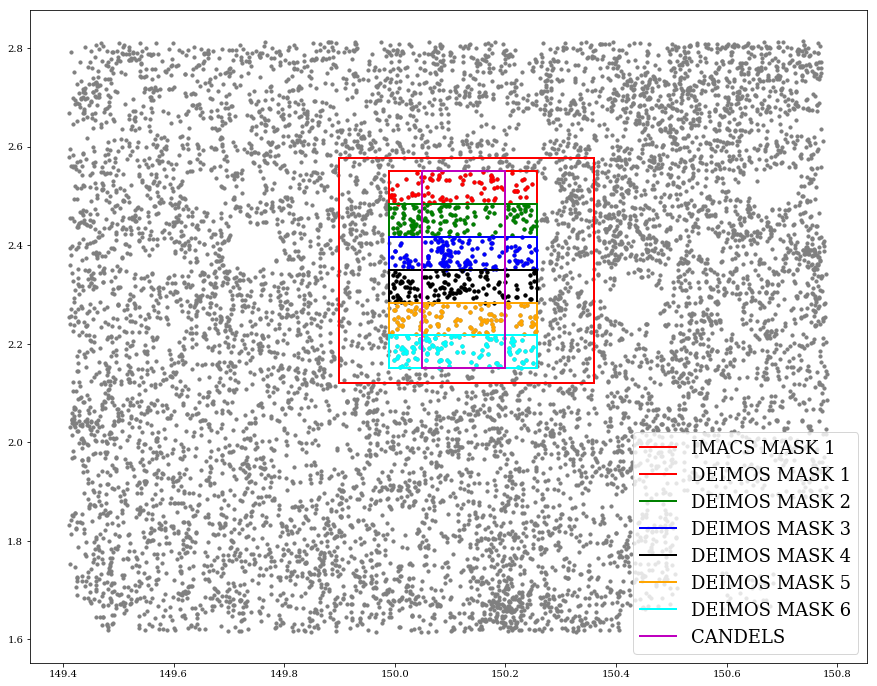

In [14]:
fig = plt.figure(figsize=(15,12))
plt.scatter(sample1_total['ALPHA_J2000'],sample1_total['DELTA_J2000'],s=10,c='grey')
#IMACS FOV
plt.plot([149.90,149.90],[2.12,2.578],linewidth=2,c='r',label='IMACS MASK 1')
plt.plot([150.36,150.36],[2.12,2.578],linewidth=2,c='r')
plt.plot([149.90,150.36],[2.12,2.12],linewidth=2,c='r')
plt.plot([149.90,150.36],[2.578,2.578],linewidth=2,c='r')

# DEIMOS MASK 1
plt.plot([149.99,149.99],[2.483,2.55],linewidth=2,c='r',label='DEIMOS MASK 1')
plt.plot([150.257,150.257],[2.483,2.55],linewidth=2,c='r')
plt.plot([149.99,150.257],[2.483,2.483],linewidth=2,c='r')
plt.plot([149.99,150.257],[2.55,2.55],linewidth=2,c='r')
# DEIMOS MASK 2
plt.plot([149.99,149.99],[2.417,2.483],linewidth=2,c='g',label='DEIMOS MASK 2')
plt.plot([150.257,150.257],[2.417,2.483],linewidth=2,c='g')
plt.plot([149.99,150.257],[2.417,2.417],linewidth=2,c='g')
plt.plot([149.99,150.257],[2.483,2.483],linewidth=2,c='g')
# DEIMOS MASK 3
plt.plot([149.99,149.99],[2.350,2.417],linewidth=2,c='b',label='DEIMOS MASK 3')
plt.plot([150.257,150.257],[2.350,2.417],linewidth=2,c='b')
plt.plot([149.99,150.257],[2.350,2.350],linewidth=2,c='b')
plt.plot([149.99,150.257],[2.417,2.417],linewidth=2,c='b')
# DEIMOS MASK 4
plt.plot([149.99,149.99],[2.283,2.350],linewidth=2,c='k',label='DEIMOS MASK 4')
plt.plot([150.257,150.257],[2.283,2.350],linewidth=2,c='k')
plt.plot([149.99,150.257],[2.283,2.283],linewidth=2,c='k')
plt.plot([149.99,150.257],[2.350,2.350],linewidth=2,c='k')
# DEIMOS MASK 5
plt.plot([149.99,149.99],[2.217,2.283],linewidth=2,c='orange',label='DEIMOS MASK 5')
plt.plot([150.257,150.257],[2.217,2.283],linewidth=2,c='orange')
plt.plot([149.99,150.257],[2.217,2.217],linewidth=2,c='orange')
plt.plot([149.99,150.257],[2.283,2.283],linewidth=2,c='orange')
# DEIMOS MASK 6
plt.plot([149.99,149.99],[2.150,2.217],linewidth=2,c='cyan',label='DEIMOS MASK 6')
plt.plot([150.257,150.257],[2.150,2.217],linewidth=2,c='cyan')
plt.plot([149.99,150.257],[2.150,2.150],linewidth=2,c='cyan')
plt.plot([149.99,150.257],[2.217,2.217],linewidth=2,c='cyan')

#CANDELS field
plt.plot([150.05,150.05],[2.15,2.55],linewidth=2,c='m',label='CANDELS')
plt.plot([150.2,150.2],[2.15,2.55],linewidth=2,c='m')
plt.plot([150.05,150.2],[2.15,2.15],linewidth=2,c='m')
plt.plot([150.05,150.2],[2.55,2.55],linewidth=2,c='m')


plt.scatter(sample_MASK_1['ALPHA_J2000'],sample_MASK_1['DELTA_J2000'],s=10,c='r')
plt.scatter(sample_MASK_2['ALPHA_J2000'],sample_MASK_2['DELTA_J2000'],s=10,c='g')
plt.scatter(sample_MASK_3['ALPHA_J2000'],sample_MASK_3['DELTA_J2000'],s=10,c='b')
plt.scatter(sample_MASK_4['ALPHA_J2000'],sample_MASK_4['DELTA_J2000'],s=10,c='k')
plt.scatter(sample_MASK_5['ALPHA_J2000'],sample_MASK_5['DELTA_J2000'],s=10,c='orange')
plt.scatter(sample_MASK_6['ALPHA_J2000'],sample_MASK_6['DELTA_J2000'],s=10,c='cyan')

plt.legend(loc='lower right',fontsize=18)
plt.show()